# Proyek Klasifikasi Gambar: [Intel-image-classification]
- **Nama:** geervan thanra
- **Email:** mc008d5y2414@student.devacademy.id
- **ID Dicoding:** Bread

## Import Semua Packages/Library yang Digunakan

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import cv2
import skimage
import os
import shutil
import random
import json
from PIL import Image
from skimage.transform import rotate, resize
from skimage import img_as_ubyte
from tqdm.notebook import tqdm as tqdm
import warnings

In [7]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [8]:
#kaggle directories
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [9]:
def get_all(pathdir):
    image_paths = []
    for root, dirs, files in os.walk(pathdir):
        for file in files:
            if file.lower():
                fullpath = os.path.join(root, file)
                image_paths.append(fullpath)
    return image_paths

In [10]:
img_train = get_all(train_dir)
img_test = get_all(test_dir)

print(len(img_train))
print(len(img_test))

14034
3000


In [32]:
def show_images(imagePath, title="Images"):
    plt.figure(figsize=(20, 5))
    for i, img_path in enumerate(imagePath):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(imagePath), i + 1)
        plt.imshow(img_rgb)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

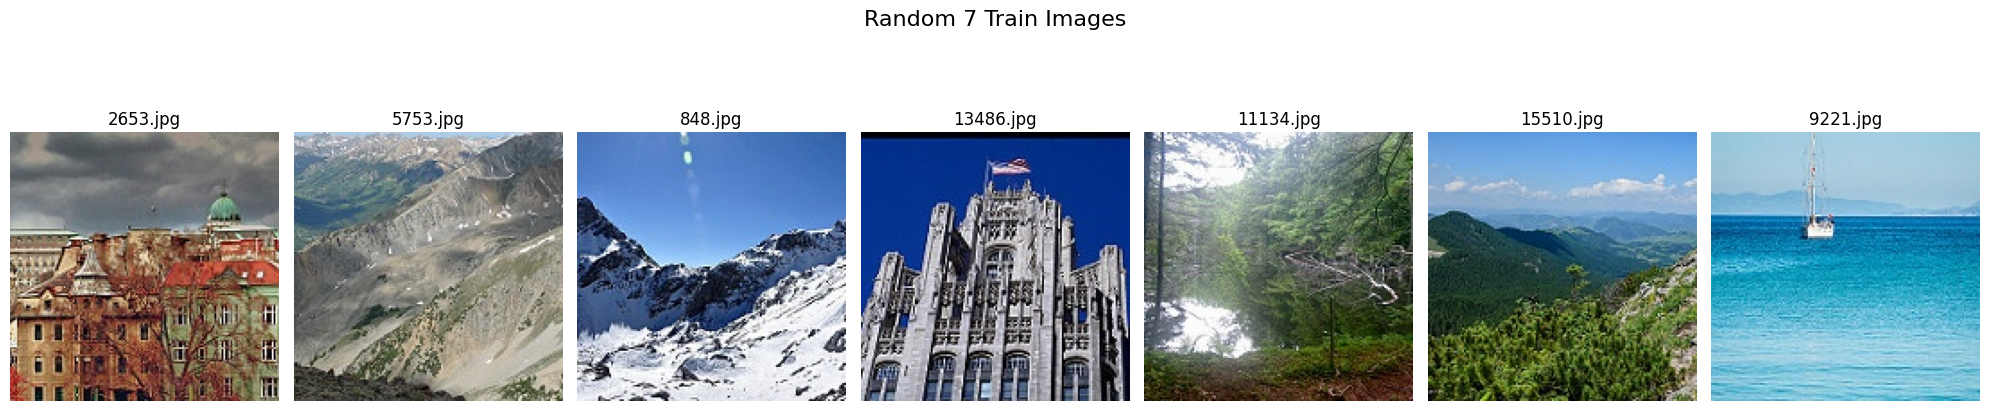

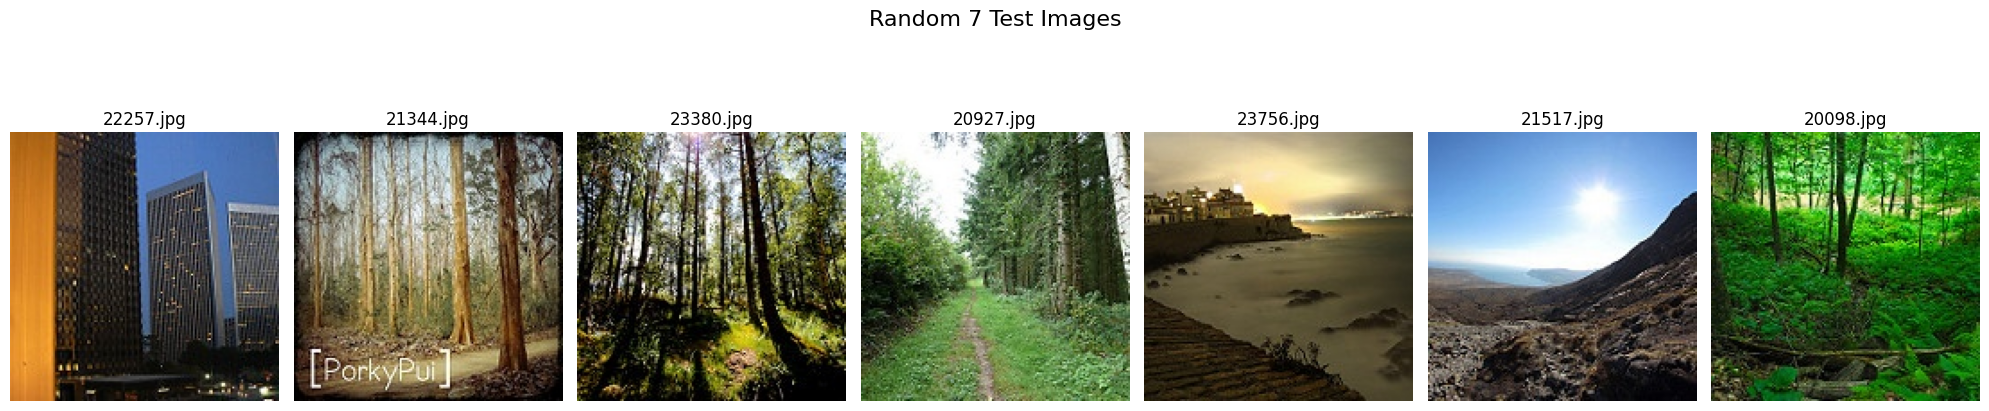

In [98]:
ran_train = random.sample(img_train, 7)
ran_test = random.sample(img_test, 7)

show_images(ran_train, title="Random 7 Train Images")
show_images(ran_test, title="Random 7 Test Images")

In [11]:
#check subfolders
sub_folder =[]
for dirs in os.scandir(train_dir):
    sub_folder.append(dirs.name)
    print(dirs.name)

mountain
street
buildings
sea
forest
glacier


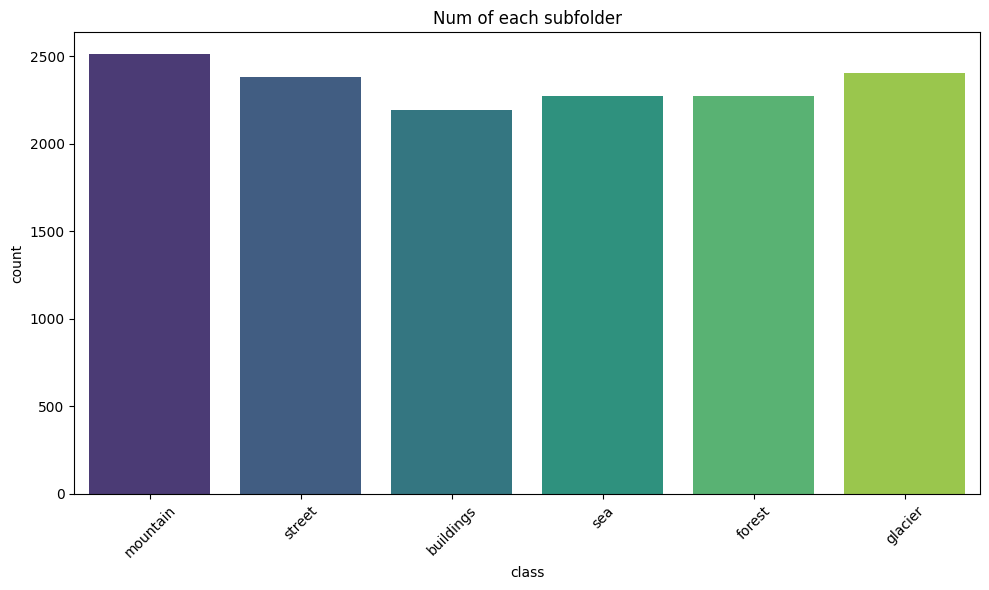

In [58]:
subfolder_counts = []
for k in os.scandir(train_dir):
    if k.is_dir():
        files = os.listdir(k.path)
        count = len([f for f in files])
        subfolder_counts.append( count)

frame = pd.DataFrame({
    'class': sub_folder,
    'count': subfolder_counts
})

plt.figure(figsize=(10, 6))
sns.barplot(data=frame, x='class', y='count', palette='viridis')
plt.title("Num of each subfolder")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

dari grafik diatas dapat diperhatikan bahwa num data pada setiap class cukup deket

### Data Preprocessing

#### Split Dataset

In [12]:
#df
class_name_label = {sub: i for i, sub in enumerate(sub_folder)}
print(class_name_label)
print(len(class_name_label))

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}
6


In [13]:
#preprocessing
img_size = 150

def pull_data():
    data = [train_dir, test_dir]
    output = []

    for n in data:
        images = []
        labels = []

        for subfolder in os.listdir(n):
            label = class_name_label[subfolder]
            sub_path = os.path.join(n, subfolder)
    
            for file in tqdm(os.listdir(sub_path), desc=f"{sub_path}"):
                    img_path = os.path.join(sub_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
            
                    images.append(img)
                    labels.append(label)

        images = np.array(images, dtype='float32')/255
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

In [14]:
(train_images, train_labels), (test_images, test_labels) = pull_data()

train_images, train_labels = shuffle(train_images, train_labels,
                                     random_state=42)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Val Images Shape:", val_images.shape)
print("Val Labels Shape:", val_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain:   0%|          | 0/2512 [00:00<?, ?it/s…

/kaggle/input/intel-image-classification/seg_train/seg_train/street:   0%|          | 0/2382 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/buildings:   0%|          | 0/2191 [00:00<?, ?it/…

/kaggle/input/intel-image-classification/seg_train/seg_train/sea:   0%|          | 0/2274 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/forest:   0%|          | 0/2271 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/glacier:   0%|          | 0/2404 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/mountain:   0%|          | 0/525 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/street:   0%|          | 0/501 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/buildings:   0%|          | 0/437 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/sea:   0%|          | 0/510 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/forest:   0%|          | 0/474 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/glacier:   0%|          | 0/553 [00:00<?, ?it/s]

Train Images Shape: (11227, 150, 150, 3)
Train Labels Shape: (11227,)
Val Images Shape: (2807, 150, 150, 3)
Val Labels Shape: (2807,)
Test Images Shape: (3000, 150, 150, 3)
Test Labels Shape: (3000,)


In [39]:
train_df = pd.DataFrame({
    'image': list(train_images),
    'label': train_labels
})


test_df = pd.DataFrame({
    'image': list(test_images),
    'label': test_labels
})

In [40]:
train_df

,image,label
0,"[[[0.105882354, 0.2, 0.27058825], [0.22352941,...",1
1,"[[[0.95686275, 0.9490196, 0.94509804], [0.9568...",2
2,"[[[0.80784315, 0.7411765, 0.65882355], [0.8078...",0
3,"[[[0.96862745, 1.0, 1.0], [0.98039216, 0.98823...",2
4,"[[[0.6627451, 0.63529414, 0.6], [0.65882355, 0...",5
...,...,...
11222,"[[[0.64705884, 0.49803922, 0.40392157], [0.650...",5
11223,"[[[0.9764706, 0.8862745, 0.7372549], [0.976470...",0
11224,"[[[0.89411765, 0.6901961, 0.43137255], [0.8980...",0
11225,"[[[0.8666667, 0.8117647, 0.7882353], [0.862745...",0


In [ ]:
test_df

,image,label
0,"[[[0.7294118, 0.5686275, 0.50980395], [0.73333...",0
1,"[[[0.5529412, 0.5372549, 0.5176471], [0.556862...",0
2,"[[[0.7764706, 0.75686276, 0.7647059], [0.76862...",0
3,"[[[0.77254903, 0.5647059, 0.3647059], [0.76862...",0
4,"[[[0.8980392, 0.8039216, 0.6862745], [0.929411...",0
...,...,...
2995,"[[[0.9647059, 0.94509804, 0.9490196], [0.96078...",5
2996,"[[[0.98039216, 0.98039216, 0.95686275], [0.980...",5
2997,"[[[0.83137256, 0.5019608, 0.24313726], [0.8431...",5
2998,"[[[0.8627451, 0.5764706, 0.4509804], [0.866666...",5


## Modelling

In [ ]:
input_shape = (150,150,3)

In [52]:
def model ():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape= input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation ='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation ='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation ='relu'))
    model.add(Dense(6, activation ='softmax'))

    return model

In [53]:
cnn_model = model()
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 148, 148, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 148, 148, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 146, 146, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 71, 71, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,751,678 (6.68 MB)

 Trainable params: 1,749,662 (6.67 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [54]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=False,
    verbose=1
)

In [55]:
cnn_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

history = cnn_model.fit(train_images, train_labels,
                  batch_size=16,
                  epochs=50,
                  validation_data=(val_images, val_labels),
                  callbacks=[early_stop]  
                       )

Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.3313 - loss: 1.6199 - val_accuracy: 0.6067 - val_loss: 0.9667
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6168 - loss: 1.0001 - val_accuracy: 0.6437 - val_loss: 0.9855
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7218 - loss: 0.8020 - val_accuracy: 0.7467 - val_loss: 0.7355
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7498 - loss: 0.7375 - val_accuracy: 0.7695 - val_loss: 0.6522
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7846 - loss: 0.6442 - val_accuracy: 0.7823 - val_loss: 0.6149
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8019 - loss: 0.5941 - val_accuracy: 0.8112 - val_loss: 0.5670
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8252 - loss: 0.5438 - val_accuracy: 0.5625 - val_loss: 1.1542
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8357 - loss: 0.5144 - 

## Evaluasi dan Visualisasi

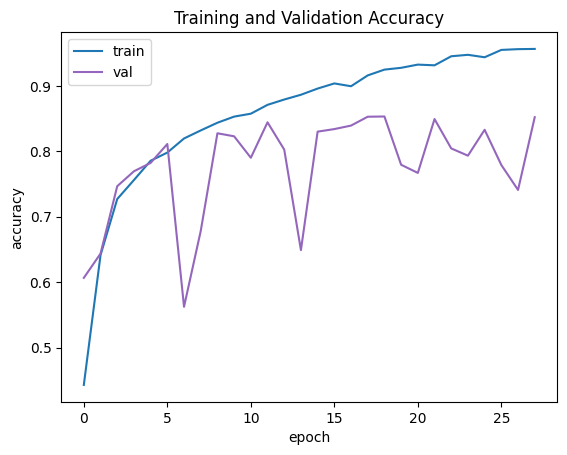

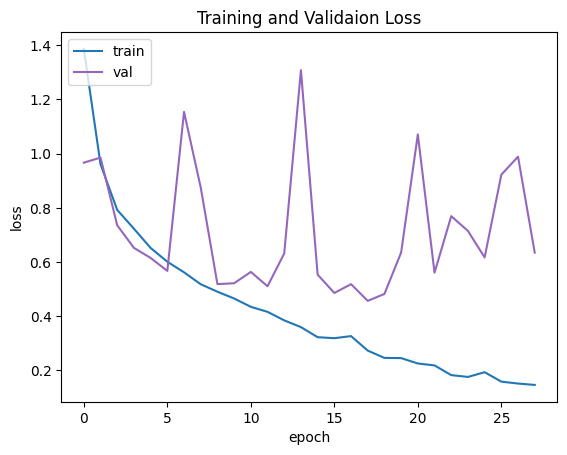

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'tab:blue')
plt.plot(epochs, val_acc, 'tab:purple')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'tab:blue')
plt.plot(epochs, val_loss, 'tab:purple')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


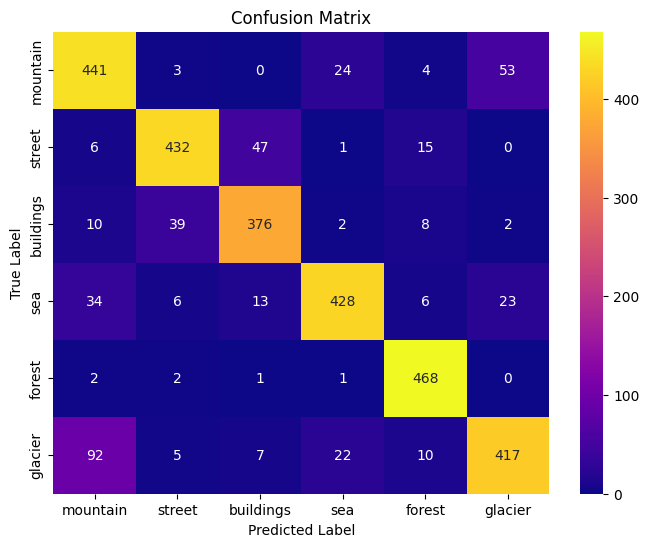

In [69]:
pred_probs = cnn_model.predict(test_images)
pred = np.argmax(pred_probs , axis=1)
test_labels_np = np.array(test_labels)

cm = confusion_matrix(test_labels_np, pred, labels=[0, 1, 2, 3, 4, 5])

df_cm = pd.DataFrame(cm, index=sub_folder, columns=sub_folder)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="plasma", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [66]:
df_cm

,mountain,street,buildings,sea,forest,glacier
mountain,441,3,0,24,4,53
street,6,432,47,1,15,0
buildings,10,39,376,2,8,2
sea,34,6,13,428,6,23
forest,2,2,1,1,468,0
glacier,92,5,7,22,10,417


## Konversi Model

In [71]:
#save model
cnn_model.save('model_img_classification.keras')

In [73]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [85]:
#convert into tf.js
cnn_model.save('/kaggle/working/img_classification_real.h5')

In [91]:
!tensorflowjs_converter --input_format=keras /kaggle/working/img_classification_real.h5 tfjs_model

2025-04-23 15:20:35.521173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745421635.544545   14684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745421635.551815   14684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [92]:
import shutil
shutil.make_archive('/kaggle/working/tfjs_model', 'zip', '/kaggle/working/tfjs_model')

'/kaggle/working/tfjs_model.zip'

In [93]:
#tf lite
model = tf.keras.models.load_model('/kaggle/working/img_classification_real.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/kaggle/working/img_classification_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt39lvxjm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140633640908944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538195344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538191312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538192464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538202064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538191504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630538200528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633642822992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633642822608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1406336428241

W0000 00:00:1745421894.719938   12142 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745421894.719991   12142 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745421894.747108   12142 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [96]:
cnn_model.export('/kaggle/working/img_classification_real')

Saved artifact at '/kaggle/working/img_classification_real'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_1336')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140630110178192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110188752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110190864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110191248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110189712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110190096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110190672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630110190288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630068894544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140630068894928: TensorSpec(shape=(), dtype=tf.resource,

In [97]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.16
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.1
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.6.0
arrow==1.3.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.10.0.33.26
asttokens==3.0.0
astunparse==1.6.3
atpublic==4.1.0
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.36.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blobfile==3.0.0
blosc2==3.1.0
bokeh==3.6.3
Boruta==0.4.3
boto3==1.37.29
botocore==1.37.29
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_hel

In [100]:
labels = sub_folder

with open('/kaggle/working/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")